<a href="https://colab.research.google.com/github/sotamorita/Chest-Xray/blob/main/chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの学習
※ Google Colabで実行

In [ ]:
# ライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [ ]:
# npyファイル読み込み
X_train = np.load('/content/drive/MyDrive/python/chest_xray/X_train2.npy')
Y_train = np.load('/content/drive/MyDrive/python/chest_xray/Y_train2.npy')
X_train = X_train.astype(np.float32)
X_train = X_train / 255.0

X_valid = np.load('/content/drive/MyDrive/python/chest_xray/X_valid2.npy')
Y_valid = np.load('/content/drive/MyDrive/python/chest_xray/Y_valid2.npy')
X_valid = X_valid.astype(np.float32)
X_valid = X_valid / 255.0

In [ ]:
# XとYの対応関係を保ったままシャッフル
seed_train = np.random.permutation(len(X_train))
X_train = X_train[seed_train]
Y_train = Y_train[seed_train]
seed_valid = np.random.permutation(len(X_valid))
X_valid = X_valid[seed_valid]
Y_valid = Y_valid[seed_valid]

In [ ]:
# データの拡張
datagen = ImageDataGenerator(
        rotation_range=20, 
        zoom_range=0.15, 
        width_shift_range=0.15, 
        height_shift_range=0.15, 
        # brightness_range=[0.99, 1.01]
        )

In [ ]:
"""
# NORMALとPNEUMONIAの比から重みを計算
num_n = 0
num_p = 0
num_train = len(Y_train)
for y in Y_train:
    if y[0] == 1:
        num_n += 1
    else:
        num_p += 1
print("train data")
print(f"# of normal: {num_n}")
print(f"# of pneumonia: {num_p}")

weight_for_0 = (1/num_n) * (num_train) / 2.0 
weight_for_1 = (1/num_p) * (num_train) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for normal   : {:.2f}'.format(weight_for_0))
print('Weight for pneumonia: {:.2f}'.format(weight_for_1))
"""

'\n# NORMALとPNEUMONIAの比から重みを計算\nnum_n = 0\nnum_p = 0\nnum_train = len(Y_train)\nfor y in Y_train:\n    if y[0] == 1:\n        num_n += 1\n    else:\n        num_p += 1\nprint("train data")\nprint(f"# of normal: {num_n}")\nprint(f"# of pneumonia: {num_p}")\n\nweight_for_0 = (1/num_n) * (num_train) / 2.0 \nweight_for_1 = (1/num_p) * (num_train) / 2.0\n\nclass_weight = {0: weight_for_0, 1: weight_for_1}\n\nprint(\'Weight for normal   : {:.2f}\'.format(weight_for_0))\nprint(\'Weight for pneumonia: {:.2f}\'.format(weight_for_1))\n'

In [ ]:
# モデルの定義
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# model.summary()

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

model = Model(inputs=model.input, outputs=top_model(model.output))

model.summary()

for layer in model.layers[:15]:
    layer.trainable = False


# 学習率のスケジューリング
def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = keras.callbacks.LearningRateScheduler(scheduler)
'''
# Early Stopping
callback = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)
'''
opt = RMSprop(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
# 学習の実施
batch_size_train = 128
batch_size_valid = 32
epochs = 40
log = model.fit(
    datagen.flow(X_train, Y_train, batch_size_train),
    steps_per_epoch=len(X_train) // batch_size_train,
    epochs=epochs,
    verbose=True,
    validation_data=datagen.flow(X_valid, Y_valid, batch_size=batch_size_valid),
    validation_steps=len(X_valid) // batch_size_valid,
    callbacks=[callback], 
    # class_weight=class_weight, 
    )

Epoch 1/40
32/32 [==============================] - 84s 2s/step - loss: 0.4067 - accuracy: 0.8326 - val_loss: 0.2248 - val_accuracy: 0.9004
Epoch 2/40
32/32 [==============================] - 52s 2s/step - loss: 0.2103 - accuracy: 0.9177 - val_loss: 0.1424 - val_accuracy: 0.9395
Epoch 3/40
32/32 [==============================] - 52s 2s/step - loss: 0.1848 - accuracy: 0.9236 - val_loss: 0.1234 - val_accuracy: 0.9561
Epoch 4/40
32/32 [==============================] - 52s 2s/step - loss: 0.1415 - accuracy: 0.9465 - val_loss: 0.1063 - val_accuracy: 0.9629
Epoch 5/40
32/32 [==============================] - 52s 2s/step - loss: 0.1312 - accuracy: 0.9522 - val_loss: 0.1485 - val_accuracy: 0.9414
Epoch 6/40
32/32 [==============================] - 53s 2s/step - loss: 0.1121 - accuracy: 0.9583 - val_loss: 0.1094 - val_accuracy: 0.9580
Epoch 7/40
32/32 [==============================] - 53s 2s/step - loss: 0.1067 - accuracy: 0.9615 - val_loss: 0.1026 - val_accuracy: 0.9561
Epoch 8/40
32/32 [==

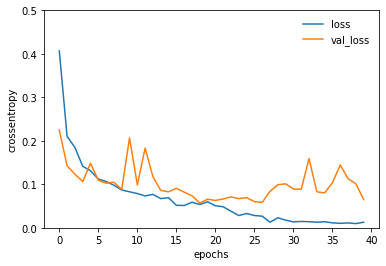

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.ylim(0.0, 0.5)
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

In [ ]:
# npyファイル読み込み
X_test = np.load('/content/drive/MyDrive/python/chest_xray/X_test2.npy')
Y_test = np.load('/content/drive/MyDrive/python/chest_xray/Y_test2.npy')
X_test = X_test.astype(np.float32)
X_test = X_test / 255.0

In [ ]:
# テストデータで予測
Y_pred = np.argmax(model.predict(X_test), axis=1)

# カテゴリー変数の復元
Y_test_ = np.argmax(Y_test, axis=1)

from sklearn.metrics import classification_report
print(classification_report(Y_test_, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       234
           1       0.94      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



In [ ]:
num_n = 0
num_p = 0
for pred in Y_pred:
    if pred == 0:
        num_n += 1
    else:
        num_p += 1
print("predict data")
print(f"# of normal: {num_n}")
print(f"# of pneumonia: {num_p}")

predict data
# of normal: 218
# of pneumonia: 406


In [ ]:
# モデルをmodel.jsonとして保存
path = "/content/drive/MyDrive/python/chest_xray/"
with open (path + "model_data2.json", "w") as json_file:
    json_file.write(model.to_json())

# パラメータをweight.h5として保存
model.save_weights(path + "weight_data2.h5")

In [ ]:
np.save(path + "Y_pred2", Y_pred)